# AirBnB Data Exploration


In [1]:
# import libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
from helpers import price_parse, fit_prepare, valid_value_intbool

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

## Load and Pre-Process

In [3]:
# read data files
# Boston
b_lis = pd.read_csv('data/boston/listings.csv', sep=',', header=0, 
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated', 
                                 'calendar_last_scraped', 'first_review', 'last_review'], 
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse, 
                                'monthly_price': price_parse, 'security_deposit': price_parse, 
                                'cleaning_fee': price_parse, 'extra_people': price_parse},
                    true_values=['t'], false_values=['f'])
ber_lis = pd.read_csv('data/berlin/listings_summary.csv', sep=',', header=0, 
                    parse_dates=['last_scraped', 'host_since', 'calendar_updated', 
                                 'calendar_last_scraped', 'first_review', 'last_review'], 
                    infer_datetime_format=True,
                    converters={'price': price_parse, 'weekly_price': price_parse, 
                                'monthly_price': price_parse, 'security_deposit': price_parse, 
                                'cleaning_fee': price_parse, 'extra_people': price_parse},
                    true_values=['t'], false_values=['f'])

C:\Users\ruindur\.conda\envs\airbnb_blog\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (28,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# join tables, all-missing columns
#calendar = pd.concat([b_cal, s_cal, ber_cal], axis=0, ignore_index=True, sort=False).dropna(how='all', axis=1)
listings = pd.concat([b_lis.assign(**{'source': lambda x: 'Boston'}), 
                      ber_lis.assign(**{'source': lambda x: 'Berlin'})], axis=0, 
                     ignore_index=True, sort=False).dropna(how='all', axis=1)
#reviews = pd.concat([b_rev, s_rev, ber_rev], axis=0, ignore_index=True, sort=False).dropna(how='all', axis=1)

In [10]:
# column categories
listings_categorical = ['experiences_offered', 'host_location', 'host_response_time', 
                        'host_response_rate', 'host_acceptance_rate', 'host_neighbourhood',
                        'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 
                        'state', 'zipcode', 'market', 'source', 'smart_location', 
                        'property_type', 'cancellation_policy',
                        'room_type', 'bed_type', 'calendar_updated']
listings_presence = []
listings_text = ['name', 'summary', 'space', 'description', 'notes', 'neighborhood_overview', 
                 'transit', 'host_about', 'host_name', 'street', 'neighborhood']
listings_multi_categories = ['host_verifications', 'amenities']
listings_numeric = listings.select_dtypes('number').columns

In [11]:
for col in listings_numeric:
    print(listings[col].value_counts())

16322558    1
11550637    1
26734487    1
9996186     1
20359070    1
           ..
17874082    1
17544355    1
885925      1
12227751    1
10749953    1
Name: id, Length: 26137, dtype: int64
20181107122246    22552
20160906204935     3585
Name: scrape_id, dtype: int64
30283594    136
25188        79
9419684      61
12243051     58
22348222     50
           ... 
85881540      1
813767        1
1774280       1
91652810      1
1015808       1
Name: host_id, Length: 21359, dtype: int64
1.0       17769
2.0        3899
3.0        1258
4.0         602
5.0         361
6.0         272
7.0         234
749.0       136
8.0         115
9.0         115
11.0        114
12.0        108
19.0         92
558.0        79
18.0         69
313.0        61
14.0         59
363.0        58
30.0         54
10.0         54
16.0         52
52.0         50
15.0         48
24.0         48
22.0         45
59.0         45
17.0         45
43.0         43
13.0         36
26.0         26
307.0        25
0.0          25

In [12]:
# actual URLs are not interesting, but presence could be of value
for col in listings.columns:
    if 'url' in col:
        pcol = 'has_' + col
        listings[pcol] = listings[col].apply(valid_value_intbool, convert_dtype=True)
        listings.drop(col, axis=1, inplace=True)
        listings_presence.append(pcol)

In [13]:
listings_all_same = []
for col in listings_categorical:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_categorical.remove(col)  

for col in listings_presence:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_presence.remove(col)  

for col in listings_numeric:
    if listings[col].value_counts(dropna=False).shape[0] == 1:
        listings_all_same.append(col)
        listings_numeric.remove(col)  
        
listings = listings.drop(listings_all_same, axis=1)
listings.sample(10)

,id,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,...,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,source,is_business_travel_ready,has_thumbnail_url,has_medium_url,has_xl_picture_url,has_host_thumbnail_url,has_host_picture_url
2751,10381729,20160906204935,2016-09-07,Nice apartment with open floor plan,Large 1 bedroom in a spacious and comfortable ...,NaN,Large 1 bedroom in a spacious and comfortable ...,NaN,NaN,NaN,...,False,2,5.23,Boston,NaN,1,1,1,1,1
7551,6184648,20181107122246,2018-11-07,Prenzlauerberg-Beautiful and handy!,Heyo everybody. I have a one-bedroom apartment...,In a beautiful region of town- Prenzlauerberg....,Heyo everybody. I have a one-bedroom apartment...,"Great connection with the public transport, 7 ...",NaN,See above!,...,False,1,0.14,Berlin,False,1,1,1,1,1
18448,20769875,20181107122246,2018-11-07,MITTE art gallery +central Rosenthaler Platz U...,"Travelling to Berlin for work, academic purpos...",This old-style Berlin apartment has a fully eq...,"Travelling to Berlin for work, academic purpos...",The apartment is centrally located in Berlin M...,Dieses WG-Zimmer ist nur für längere Aufenthal...,NaN,...,False,1,1.24,Berlin,False,1,1,1,1,1
10408,9856741,20181107122246,2018-11-07,Sommerurlaub in Berlin Kreuzkölln,"Wunderschöne, ruhige 2-Zimmer Wohnung (1 Schla...",1 Schlafzimmer 1 Wohnzimmer 1 Badezimmer 1 Küche,"Wunderschöne, ruhige 2-Zimmer Wohnung (1 Schla...",NaN,NaN,"U8, U7 Hermannplatz Bus",...,False,1,0.06,Berlin,False,1,1,1,1,1
22379,24820203,20181107122246,2018-11-07,Stunning Friedrichshain Apartment on the River,Beautiful apartment in the heart of Berlin onl...,This apartment is my home and primary residenc...,Beautiful apartment in the heart of Berlin onl...,Friedrichshain is one of the most desirable ne...,NaN,Public transit is excellent with access to loc...,...,False,1,0.50,Berlin,False,1,1,1,1,1
8150,7006061,20181107122246,2018-11-07,Fantastic apartment in Berlin,Beautifully finished apartment with big kitche...,Beautiful big and quiet apartment with great k...,Beautifully finished apartment with big kitche...,"Quiet and green neighborhood, only a short str...",NaN,S-Bahn is the best and very close. There is a ...,...,False,1,0.09,Berlin,False,1,1,1,1,1
14063,15815171,20181107122246,2018-11-07,Berlin prime location Apartment with highstandard,"My apartment occupies a prime, central spot on...",The spacious apartment (87sqm) has two separat...,"My apartment occupies a prime, central spot on...",Enjoy shopping trips in the Potsdamer Platz Ar...,NaN,Nearest subway station. - And Suburban train s...,...,False,2,1.35,Berlin,False,1,1,1,1,1
21838,24008347,20181107122246,2018-11-07,2-Zi-Wohnung in Mitte,Moderne offene 2-Zimmer-Wohnung zentral zwisch...,NaN,Moderne offene 2-Zimmer-Wohnung zentral zwisch...,NaN,NaN,NaN,...,False,1,NaN,Berlin,False,1,1,1,1,1
14824,16799799,20181107122246,2018-11-07,[RXL] 28 Gäste · 14 Zi-Haus · U6 + SBahn Tempe...,FÜR BIS ZU 28 PERSONEN • Ganzes Haus auf zwei ...,ACHTUNG: AIRBNBs Webseite hat soooo! große Häu...,FÜR BIS ZU 28 PERSONEN • Ganzes Haus auf zwei ...,"Wie Du wahrscheinlich weißt, sind FERIENWOHNUN...",NaN,"U6 Tempelhof ca 3 Minuten S41, S42 Tempelhof c...",...,False,9,0.30,Berlin,False,1,1,1,1,1
25082,28603113,20181107122246,2018-11-07,Quiet cosy room/flat Heart of Berlin,Room is quiet and area is nice with restaurant...,"THe area is nice, safe and quiet (flat is in t...",Room is quiet and area is nice with restaurant...,NaN,Unfortunately Airbnb offers little space for a...,NaN,...,False,2,NaN,Berlin,False,1,1,1,1,1


In [14]:
for col in listings.columns:
    if '_id' in col or '_url' in col:
        print(col)

scrape_id
host_id
host_identity_verified
has_thumbnail_url
has_medium_url
has_xl_picture_url
has_host_thumbnail_url
has_host_picture_url


In [15]:
# convert boolean columns to integer
boolcol = listings.select_dtypes('bool').columns
for col in boolcol:
    listings[col] = listings[col].apply(lambda x: int(x))

## Tables Overview

In [16]:
#sns.pairplot(listings, vars=listings_numeric)

In [17]:
#sns.pairplot(calendar)#

In [18]:
#sns.pairplot(listings, vars=listings_numeric, kind='reg')

In [20]:
X, y = fit_prepare(listings, 'review_scores_rating', listings_numeric, listings_categorical, listings_presence)
X.drop([col for col in X.columns if 'review_scores' in col], inplace=True, axis=1)
print(X['source_Boston'].value_counts())
X.sample(10)

0    18163
1     2772
Name: source_Boston, dtype: int64


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calendar_updated_a week ago,calendar_updated_never,calendar_updated_today,calendar_updated_yesterday,calendar_updated_nan,has_thumbnail_url,has_medium_url,has_xl_picture_url,has_host_thumbnail_url,has_host_picture_url
18797,21065349,20181107122246,26095658,1.0,1.0,52.549370,13.360515,2,1.0,1.0,...,0,0,0,1,0,1,1,1,1,1
3551,14566657,20160906204935,36981635,5.0,5.0,42.369265,-71.072024,3,1.0,1.0,...,1,0,0,0,0,1,1,1,1,1
19438,21662511,20181107122246,19560837,1.0,1.0,52.546573,13.436555,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
13442,14713928,20181107122246,33993187,1.0,1.0,52.485346,13.342084,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
19300,21522006,20181107122246,144049466,1.0,1.0,52.510618,13.473765,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
10581,10045303,20181107122246,45715140,1.0,1.0,52.511863,13.450793,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
15168,17309615,20181107122246,66454477,1.0,1.0,52.496631,13.302627,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
13961,15627299,20181107122246,29515318,3.0,3.0,52.510922,13.458849,4,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
14201,16036936,20181107122246,77923222,1.0,1.0,52.587447,13.280371,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
23277,26242714,20181107122246,197227115,1.0,1.0,52.568165,13.419970,4,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 * 42)

pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge())
])
alphas = np.logspace(-7, -1, 16)

PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)

In [22]:
pcvf = PCV.fit(X_train, y_train)
#pcvf = PCV.fit(X, y)

In [23]:
pcvf.best_params_

{'model__alpha': 0.1}

In [24]:
esti = pcvf.best_estimator_
print('train score: {}  | test score: {}'.format(esti.score(X_train, y_train), esti.score(X_test, y_test)))

train score: 0.22711059858283955  | test score: -0.014769040672270695


In [25]:
coeff = esti.steps[-1][1].coef_

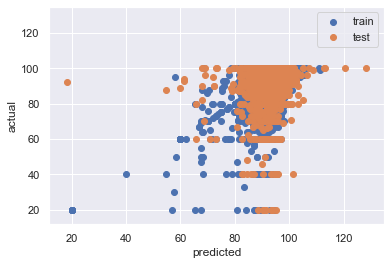

In [26]:
plt.scatter(esti.predict(X_train), y_train, label='train')
plt.scatter(esti.predict(X_test), y_test, label='test')
limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

,coefficient,coefficient_abs
latitude,9.968106,9.968106
state_Berlin,3.795257,3.795257
"host_location_Berlin, Berlin, Germany",2.521479,2.521479
calculated_host_listings_count,-2.285705,2.285705
neighbourhood_cleansed_Charlestown,2.106691,2.106691
host_neighbourhood_nan,-1.753815,1.753815
"host_location_Boston, Massachusetts, United States",1.699388,1.699388
zipcode_02129,-1.671719,1.671719
property_type_Apartment,1.473528,1.473528
source_Boston,1.428614,1.428614


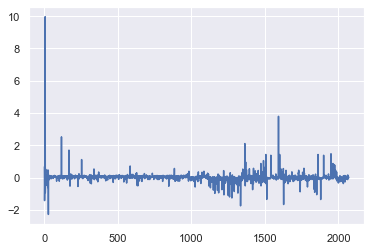

In [27]:
plt.plot(coeff)
coeff_vals = pd.DataFrame(coeff, index=X.columns, columns=['coefficient'])
coeff_vals['coefficient_abs']=np.abs(coeff_vals['coefficient'])
coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [30]:
X_bos = X[X['source_Boston'] == 1]
y_bos = y.loc[X_bos.index]
X_ber = X[X['source_Boston'] == 0]
y_ber = y.loc[X_ber.index]
print(X_bos.shape, y_bos.shape, X_ber.shape, y_ber.shape)

(2772, 2071) (2772,) (18163, 2071) (18163,)


{'model__alpha': 0.1}
Boston::  train score: 0.37420374699595205  | test score: -0.07687601025372204
Berlin::  train score: 0.20246862022541368  | test score: -0.0799194957198588


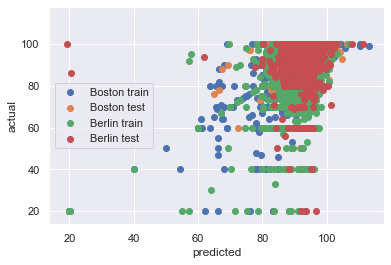

In [33]:
X_bos_train, X_bos_test, y_bos_train, y_bos_test = train_test_split(X_bos, y_bos, test_size=0.1, random_state=23 * 42)
bos_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge())
])
bos_PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)
bos_PCV_f = bos_PCV.fit(X_bos_train, y_bos_train)
print(bos_PCV_f.best_params_)

X_ber_train, X_ber_test, y_ber_train, y_ber_test = train_test_split(X_ber, y_ber, test_size=0.1, random_state=23 * 42)
ber_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=bos_PCV_f.best_params_['model__alpha']))
])

bos_pipeline.fit(X_bos_train, y_bos_train)
print('Boston::  train score: {}  | test score: {}'.format(bos_pipeline.score(X_bos_train, y_bos_train), 
                                                           bos_pipeline.score(X_bos_test, y_bos_test)))

ber_pipeline.fit(X_ber_train, y_ber_train)
print('Berlin::  train score: {}  | test score: {}'.format(ber_pipeline.score(X_ber_train, y_ber_train), 
                                                           ber_pipeline.score(X_ber_test, y_ber_test)))

plt.scatter(bos_pipeline.predict(X_bos_train), y_bos_train, label='Boston train')
plt.scatter(bos_pipeline.predict(X_bos_test), y_bos_test, label='Boston test')
plt.scatter(ber_pipeline.predict(X_ber_train), y_ber_train, label='Berlin train')
plt.scatter(ber_pipeline.predict(X_ber_test), y_ber_test, label='Berlin test')

limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

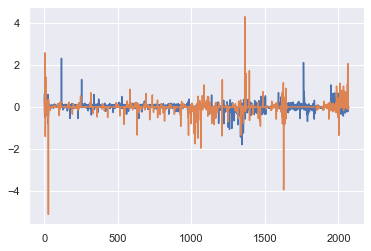

In [34]:
plt.plot(ber_pipeline.steps[-1][-1].coef_, label='Berlin')
plt.plot(bos_pipeline.steps[-1][-1].coef_, label='Boston')

In [35]:
bos_coeff_vals = pd.DataFrame(bos_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
bos_coeff_vals['coefficient_abs']=np.abs(bos_coeff_vals['coefficient'])
bos_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

,coefficient,coefficient_abs
calculated_host_listings_count,-5.123810,5.123810
neighbourhood_cleansed_Charlestown,4.304320,4.304320
zipcode_02129,-3.946576,3.946576
host_listings_count,2.580931,2.580931
host_total_listings_count,2.580931,2.580931
zipcode_02128,-2.574959,2.574959
calendar_updated_today,2.073648,2.073648
host_acceptance_rate_45%,-1.960753,1.960753
host_response_rate_79%,-1.753403,1.753403
neighbourhood_cleansed_Hyde Park,1.733771,1.733771


In [36]:
ber_coeff_vals = pd.DataFrame(ber_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
ber_coeff_vals['coefficient_abs']=np.abs(ber_coeff_vals['coefficient'])
ber_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

,coefficient,coefficient_abs
"host_location_Berlin, Berlin, Germany",2.318767,2.318767
zipcode_12524,2.117570,2.117570
latitude,1.969326,1.969326
neighbourhood_cleansed_Altglienicke,-1.798037,1.798037
host_neighbourhood_nan,-1.433124,1.433124
host_location_DE,1.309442,1.309442
neighbourhood_cleansed_Bohnsdorf,-1.237400,1.237400
host_neighbourhood_Neukölln,-1.069067,1.069067
property_type_Apartment,1.051100,1.051100
host_neighbourhood_Prenzlauer Berg,-1.018810,1.018810


In [37]:
listings['neighbourhood_cleansed'].value_counts()

Tempelhofer Vorstadt        1325
Frankfurter Allee Süd FK    1282
Alexanderplatz              1091
Reuterstraße                1002
Rixdorf                      880
                            ... 
Allende-Viertel                3
Haselhorst                     3
Neu-Hohenschönhausen Süd       2
Hellersdorf-Ost                1
MV 2                           1
Name: neighbourhood_cleansed, Length: 161, dtype: int64

In [38]:
listings['neighbourhood_cleansed'].value_counts()

Tempelhofer Vorstadt        1325
Frankfurter Allee Süd FK    1282
Alexanderplatz              1091
Reuterstraße                1002
Rixdorf                      880
                            ... 
Allende-Viertel                3
Haselhorst                     3
Neu-Hohenschönhausen Süd       2
Hellersdorf-Ost                1
MV 2                           1
Name: neighbourhood_cleansed, Length: 161, dtype: int64

In [40]:
X, y = fit_prepare(listings, 'review_scores_rating', listings_numeric, listings_categorical, listings_presence)
X.drop([col for col in X.columns if 'review_scores' in col], inplace=True, axis=1)
print(X['source_Boston'].value_counts())
X.sample(10)

0    18163
1     2772
Name: source_Boston, dtype: int64


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calendar_updated_a week ago,calendar_updated_never,calendar_updated_today,calendar_updated_yesterday,calendar_updated_nan,has_thumbnail_url,has_medium_url,has_xl_picture_url,has_host_thumbnail_url,has_host_picture_url
8715,7605268,20181107122246,29798876,1.0,1.0,52.472753,13.440524,1,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
1121,12916551,20160906204935,70833557,2.0,2.0,42.341505,-71.080875,6,1.0,1.0,...,0,0,1,0,0,1,1,1,1,1
17584,20033510,20181107122246,142281681,1.0,1.0,52.493997,13.401945,3,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
2995,3311675,20160906204935,16442921,18.0,18.0,42.311442,-71.057637,1,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
293,1071235,20160906204935,965697,2.0,2.0,42.317478,-71.108195,2,1.0,1.0,...,1,0,0,0,0,1,1,1,1,1
9922,9150173,20181107122246,19281206,2.0,2.0,52.551658,13.377670,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
3591,14325,20181107122246,55531,3.0,3.0,52.547846,13.405562,2,1.0,0.0,...,0,0,1,0,0,1,1,1,1,1
21398,23532177,20181107122246,2133004,1.0,1.0,52.543242,13.415028,2,1.0,0.0,...,0,0,0,0,0,1,1,1,1,1
18223,20599491,20181107122246,79844130,5.0,5.0,52.556854,13.348690,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1
402,12379725,20160906204935,18202088,21.0,21.0,42.333764,-71.100797,2,1.0,1.0,...,0,0,0,0,0,1,1,1,1,1


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 * 42)

pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge())
])
alphas = np.logspace(-7, -1, 16)

PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)

In [42]:
pcvf = PCV.fit(X_train, y_train)

In [43]:
pcvf.best_params_

{'model__alpha': 0.1}

In [44]:
esti = pcvf.best_estimator_
print('train score: {}  | test score: {}'.format(esti.score(X_train, y_train), esti.score(X_test, y_test)))

train score: 0.22711059858283955  | test score: -0.014769040672270695


In [45]:
coeff = esti.steps[-1][1].coef_

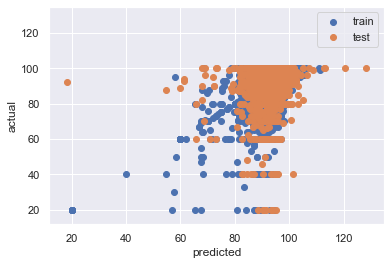

In [46]:
plt.scatter(esti.predict(X_train), y_train, label='train')
plt.scatter(esti.predict(X_test), y_test, label='test')
limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

,coefficient,coefficient_abs
latitude,9.968106,9.968106
state_Berlin,3.795257,3.795257
"host_location_Berlin, Berlin, Germany",2.521479,2.521479
calculated_host_listings_count,-2.285705,2.285705
neighbourhood_cleansed_Charlestown,2.106691,2.106691
host_neighbourhood_nan,-1.753815,1.753815
"host_location_Boston, Massachusetts, United States",1.699388,1.699388
zipcode_02129,-1.671719,1.671719
property_type_Apartment,1.473528,1.473528
source_Boston,1.428614,1.428614


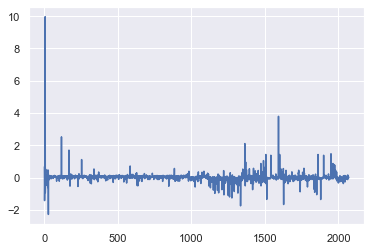

In [47]:
plt.plot(coeff)
coeff_vals = pd.DataFrame(coeff, index=X.columns, columns=['coefficient'])
coeff_vals['coefficient_abs']=np.abs(coeff_vals['coefficient'])
coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [49]:
X_bos = X[X['source_Boston'] == 1]
y_bos = y.loc[X_bos.index]
X_ber = X[X['source_Boston'] == 0]
y_ber = y.loc[X_ber.index]
print(X_bos.shape, y_bos.shape, X_ber.shape, y_ber.shape)

(2772, 2071) (2772,) (18163, 2071) (18163,)


In [50]:
X_bos_train, X_bos_test, y_bos_train, y_bos_test = train_test_split(X_bos, y_bos, test_size=0.1, random_state=23 * 42)
bos_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge())
])
bos_PCV = GridSearchCV(pipeline, {'model__alpha': alphas}, n_jobs=-1)
bos_PCV_f = bos_PCV.fit(X_sea_train, y_sea_train)
print(bos_PCV_f.best_params_)

X_ber_train, X_ber_test, y_ber_train, y_ber_test = train_test_split(X_ber, y_ber, test_size=0.1, random_state=23 * 42)
ber_pipeline = Pipeline([
    ('norm', StandardScaler()),
    ('model', Ridge(alpha=bos_PCV_f.best_params_['model__alpha']))
])

bos_pipeline.fit(X_bos_train, y_bos_train)
print('Boston::  train score: {}  | test score: {}'.format(bos_pipeline.score(X_bos_train, y_bos_train), bos_pipeline.score(X_bos_test, y_bos_test)))

ber_pipeline.fit(X_ber_train, y_ber_train)
print('Berlin::  train score: {}  | test score: {}'.format(ber_pipeline.score(X_ber_train, y_ber_train), ber_pipeline.score(X_ber_test, y_ber_test)))

plt.scatter(bos_pipeline.predict(X_bos_train), y_bos_train, label='Boston train')
plt.scatter(bos_pipeline.predict(X_bos_test), y_bos_test, label='Boston test')
plt.scatter(ber_pipeline.predict(X_ber_train), y_ber_train, label='Berlin train')
plt.scatter(ber_pipeline.predict(X_ber_test), y_ber_test, label='Berlin test')

limmin = min(plt.xlim()[0], plt.ylim()[0])
limmax = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim((limmin, limmax))
plt.ylim((limmin, limmax))
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend(loc='best')

NameError: name 'X_sea_train' is not defined

In [ ]:
plt.plot(ber_pipeline.steps[-1][-1].coef_, label='Berlin')
plt.plot(bos_pipeline.steps[-1][-1].coef_, label='Boston')

In [ ]:
bos_coeff_vals = pd.DataFrame(bos_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
bos_coeff_vals['coefficient_abs']=np.abs(bos_coeff_vals['coefficient'])
bos_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [ ]:
ber_coeff_vals = pd.DataFrame(ber_pipeline.steps[-1][-1].coef_, index=X.columns, columns=['coefficient'])
ber_coeff_vals['coefficient_abs']=np.abs(ber_coeff_vals['coefficient'])
ber_coeff_vals.sort_values(by='coefficient_abs', ascending=False).head(20)

In [ ]:
listings['neighbourhood_cleansed'].value_counts()